In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
batch_size = 64
num_epochs = 75

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [2]:
def load_datasets(base_path="./"):
    
    files = {
        "train": "loan_data.csv",
    }

    dfs = {}
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename)
        
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates 
    })
    
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    
    summary = summary.sort_values(by="missing_%", ascending=False)
    
    return summary

def check_and_drop_duplicates(df, target=None):

    total_duplicates = df.duplicated().sum()
    
    if total_duplicates > 0:
        df_cleaned = df.drop_duplicates()
        print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
        
        if target is not None:
            target_cleaned = target.loc[df_cleaned.index]
            return df_cleaned, target_cleaned
        
        return df_cleaned
    else:
        print("No duplicate rows found.")
        
        if target is not None:
            return df, target
            
        return df

def drop_target_and_ids(df):
    
    df_copy = df.copy()

    feature_cols_to_drop =["Loan_ID", "Loan_Status"];
    
    target = df_copy["Loan_Status"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)

    print(f"Returning raw features and target")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_engi = df.copy()

    outliers_idx = df_engi['CoapplicantIncome'].nlargest(1).index

    df_train_cleaned = df_engi.drop(index=outliers_idx)

    print(f"Engineer features")
    
    return df_engi
    
def drop_high_missing_cols(df, threshold=0.3):
    
    missing_frac = df.isna().mean()

    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    df_drop = df.drop(columns=hm_cols_to_drop)

    print(f"Dropping {len(hm_cols_to_drop)} columns at missing threshold >{threshold*100:.0f}%")

    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    hc_cols_to_drop = [col for col in cat_cols if df[col].nunique() > threshold]
    df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
    
    print(f"Dropping {len(hc_cols_to_drop)} high-cardinality columns (> {threshold} unique values)")
    
    return df_high, hc_cols_to_drop

def drop_correlated(df, threshold=0.95, plot=True):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    corr_matrix = df_temp.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    df_corr = df.drop(columns=corr_cols_to_drop)
    
    print(f"Dropping {len(corr_cols_to_drop)} highly correlated features")
    
    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
        plt.title("Feature Correlation Matrix")
        plt.show()
    
    return df_corr, corr_cols_to_drop

def collapse_rare_categories(df, min_freq=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    rare_maps = {}
    changed = False

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True)
        rare_cats = freqs[freqs < min_freq].index
        if len(rare_cats) > 0:
            df_copy[col] = df_copy[col].replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            changed = True
            print(f"Collapsed {len(rare_cats)} rare categories in column '{col}'")

    if not changed:
        print("Nothing to collapse")

    return df_copy, (rare_maps if changed else None)

def impute_and_scale(df, threshold=1.0):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    num_imputer = None
    cat_imputer = None
    robust_scaler = None
    std_scaler = None

    if numeric_cols:
        num_imputer = SimpleImputer(strategy='median')
        df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])

    if cat_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_cols] = cat_imputer.fit_transform(df_copy[cat_cols])

    if numeric_cols:
        skewness = df_copy[numeric_cols].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()

        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols]).astype(np.float32)

        normal_cols = [c for c in numeric_cols if c not in skewed_cols]
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols]).astype(np.float32)

    df_processed = df_copy.copy()

    print(f"Imputed and scaled features")

    return df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler

def select_features_rf(df, target, n_estimators=500, max_depth=10, random_state=42, threshold=0.0, top_n=20):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(df_temp, target)
    
    importances = pd.Series(rf.feature_importances_, index=df_temp.columns).sort_values(ascending=False)
    selected_features = importances[importances > threshold].index.tolist()
    df_selected = df[selected_features].copy() 

    top_features = importances.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features.index[::-1], top_features.values[::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances (Threshold={threshold})")
    plt.tight_layout()
    plt.show()
    
    print(f"Number of features before selection: {df.shape[1]}")
    print(f"Selected {len(selected_features)} features (threshold={threshold})")
    
    return df_selected, selected_features

def transform_val_test(df, cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if rare_maps:
        for col, rare_cats in rare_maps.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].apply(lambda x: x if x not in rare_cats else 'Other')

    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    if numeric_cols:
        df_copy[numeric_cols] = num_imputer.transform(df_copy[numeric_cols])

        if robust_scaler:
            skewed_cols = robust_scaler.feature_names_in_
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols]).astype(np.float32)

        if std_scaler:
            normal_cols = [c for c in numeric_cols if robust_scaler is None or c not in robust_scaler.feature_names_in_]
            if normal_cols:
                df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols]).astype(np.float32)

    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols and cat_imputer:
        df_copy[cat_cols] = cat_imputer.transform(df_copy[cat_cols])
    
    if selected_features:
        X_transformed = df_copy.reindex(columns=selected_features, fill_value=0)

        return X_transformed

    return df_copy

In [3]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading loan_data.csv...


In [4]:
#summary
print(dataset_summary(df_train))
print(df_train.head(5))

Dataset shape: (381, 13)
Total rows: 381
Total duplicate rows: 0
                     dtype  non_null_count  missing_count  missing_%  \
Credit_History     float64             351             30       7.87   
Self_Employed       object             360             21       5.51   
Loan_Amount_Term   float64             370             11       2.89   
Dependents          object             373              8       2.10   
Gender              object             376              5       1.31   
Education           object             381              0       0.00   
Married             object             381              0       0.00   
Loan_ID             object             381              0       0.00   
ApplicantIncome      int64             381              0       0.00   
LoanAmount         float64             381              0       0.00   
CoapplicantIncome  float64             381              0       0.00   
Property_Area       object             381              0       0.00   

In [5]:
# Drop duplicates
df_cleaned = check_and_drop_duplicates(dfs["train"])

No duplicate rows found.


In [6]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_cleaned)

Returning raw features and target


In [7]:
print(df_features.head(5))
print(target.value_counts())

  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male     Yes          1      Graduate            No             4583   
1   Male     Yes          0      Graduate           Yes             3000   
2   Male     Yes          0  Not Graduate            No             2583   
3   Male      No          0      Graduate            No             6000   
4   Male     Yes          0  Not Graduate            No             2333   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0             1508.0       128.0             360.0             1.0   
1                0.0        66.0             360.0             1.0   
2             2358.0       120.0             360.0             1.0   
3                0.0       141.0             360.0             1.0   
4             1516.0        95.0             360.0             1.0   

  Property_Area  
0         Rural  
1         Urban  
2         Urban  
3         Urban  
4         Urban  
Loan_Status
Y 

In [8]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

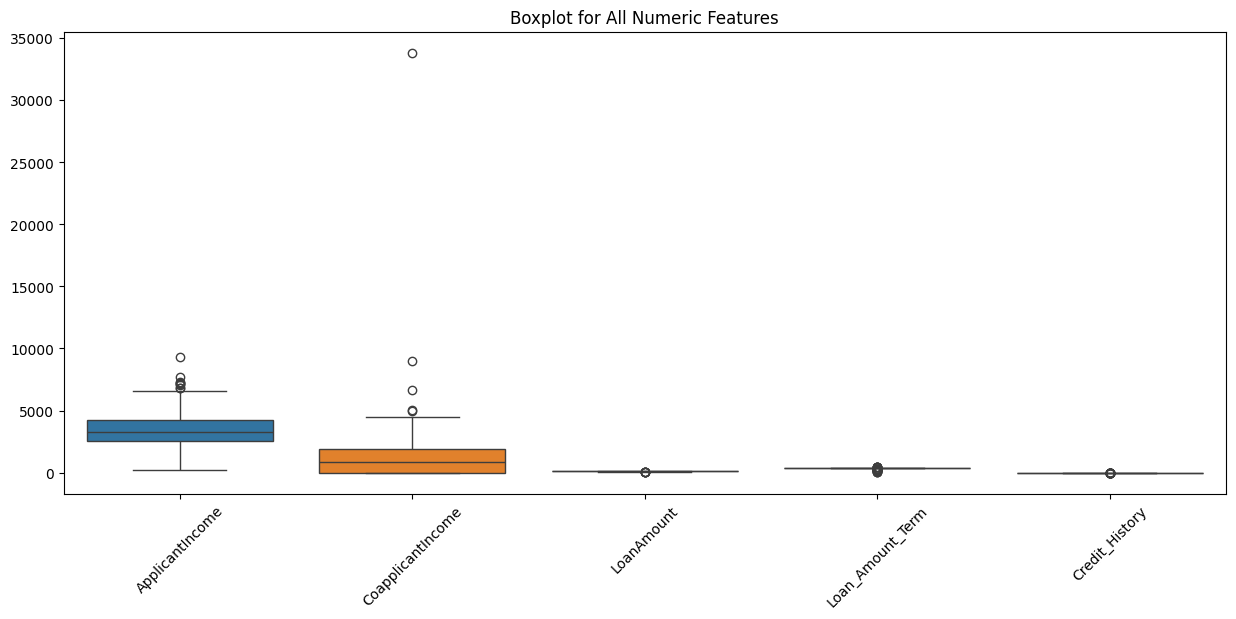

In [9]:
numeric_df = X_train.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Engineer features
X_train_engi = engineer_features(X_train)
X_val_engi = engineer_features(X_val)
X_test_engi = engineer_features(X_test)

Engineer features
Engineer features
Engineer features


In [11]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(X_train_engi, threshold=0.3)

Dropping 0 columns at missing threshold >30%


Dropping 0 highly correlated features


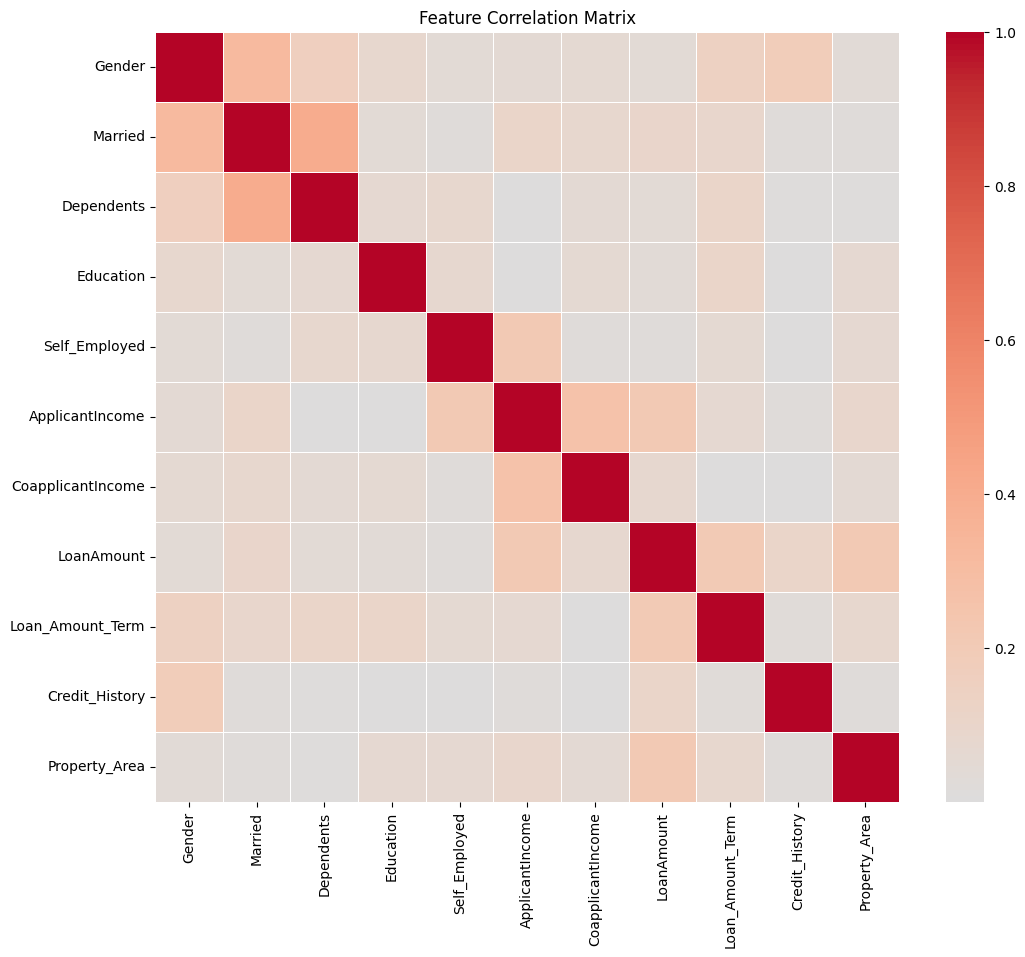

In [12]:
# Drop correlated features here
df_corr, corr_cols_to_drop = drop_correlated(df_drop, threshold=0.8)

In [13]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_corr, threshold=50)

Dropping 0 high-cardinality columns (> 50 unique values)


In [14]:
# Collapse rare categories on training data
df_collapsed, rare_maps = collapse_rare_categories(df_high, min_freq=0.005)

Nothing to collapse


In [15]:
# Impute and scale
df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler = impute_and_scale(df_collapsed, threshold=1.0)

Imputed and scaled features


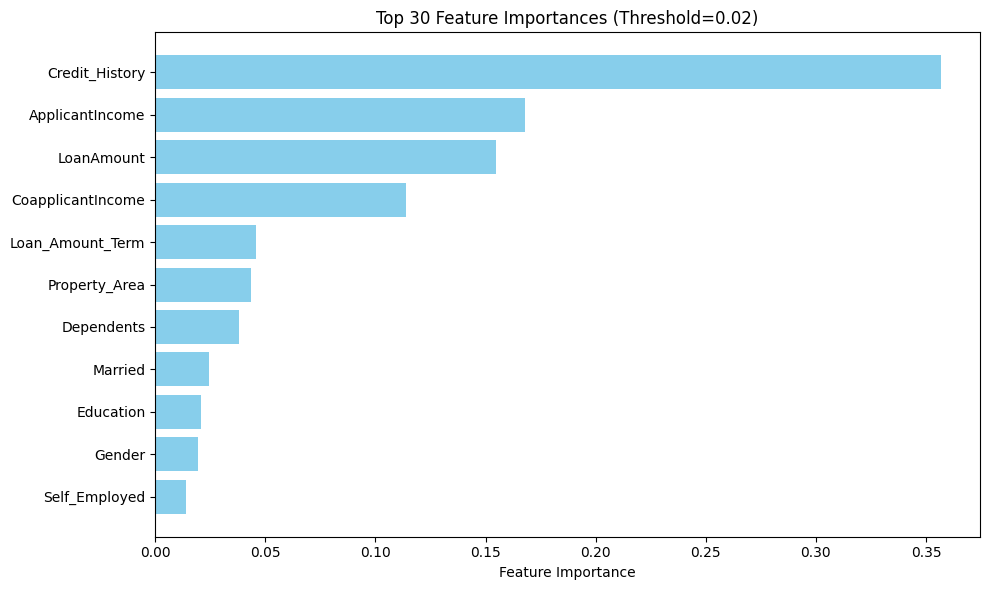

Number of features before selection: 11
Selected 9 features (threshold=0.02)


In [16]:
# Random Forest feature selection
df_selected, selected_features = select_features_rf(df_processed, y_train, threshold=0.02, top_n=30)

In [17]:
# Process
all_cols_to_drop = hm_cols_to_drop + hc_cols_to_drop + corr_cols_to_drop
X_val = transform_val_test(X_val_engi, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)
X_test = transform_val_test(X_test_engi, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)
X_train = df_selected.copy()

In [18]:
#summary
print(dataset_summary(X_train))

Dataset shape: (243, 9)
Total rows: 243
Total duplicate rows: 0
                     dtype  non_null_count  missing_count  missing_%  \
Credit_History     float32             243              0        0.0   
ApplicantIncome    float32             243              0        0.0   
LoanAmount         float32             243              0        0.0   
CoapplicantIncome  float32             243              0        0.0   
Loan_Amount_Term   float32             243              0        0.0   
Property_Area       object             243              0        0.0   
Dependents          object             243              0        0.0   
Married             object             243              0        0.0   
Education           object             243              0        0.0   

                   unique_count  duplicates_in_dataset  
Credit_History                2                      0  
ApplicantIncome             216                      0  
LoanAmount                   89             

In [19]:
# Encode
le = LabelEncoder()
y_train_encoded = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_train = le.fit_transform(y_train)  
y_val = le.transform(y_val)       
y_test = le.transform(y_test)    

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)

missing_val_cols = set(X_train.columns) - set(X_val.columns)
missing_test_cols = set(X_train.columns) - set(X_test.columns)
print("Missing in val:", missing_val_cols)
print("Missing in test:", missing_test_cols)

print("NaNs in train:", X_train.isna().sum().sum())
print("NaNs in val:", X_val.isna().sum().sum())
print("NaNs in test:", X_test.isna().sum().sum())

Train shape: (243, 16)
Val shape:   (61, 16)
Test shape:  (77, 16)
Missing in val: set()
Missing in test: set()
NaNs in train: 0
NaNs in val: 0
NaNs in test: 0


In [20]:
# Resample
train_df = X_train.copy()
train_df['target'] = y_train
classes = train_df['target'].unique()
class_dfs = {c: train_df[train_df['target'] == c] for c in classes}
max_size = train_df['target'].value_counts().max()

resampled_dfs = []
for c, df in class_dfs.items():
    if len(df) < max_size:
        df_resampled = resample(df, replace=True, n_samples=max_size, random_state=42)
    else:
        df_resampled = df
    resampled_dfs.append(df_resampled)

train_balanced = pd.concat(resampled_dfs)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced.drop('target', axis=1)
y_train_bal = train_balanced['target']

print("Before upsampling:")
print(pd.Series(y_train).value_counts())
print("After upsampling:")
print(pd.Series(y_train_bal).value_counts())
print("Number of features:", X_train_bal.shape[1])
print("X_train_balanced shape:", y_train_bal.shape)
print("y_train_balanced shape:", y_train_bal.shape)

Before upsampling:
1    173
0     70
Name: count, dtype: int64
After upsampling:
target
1    173
0    173
Name: count, dtype: int64
Number of features: 16
X_train_balanced shape: (346,)
y_train_balanced shape: (346,)


In [21]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_bal.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

In [22]:
# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 346, Val: 61, Test: 77


In [23]:
# Model
class NN(nn.Module):
    def __init__(self, num_input):
        super().__init__()
        self.fc1 = nn.Linear(num_input, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 1)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.out(x)         
        return x.squeeze(1)

num_input = X_train_bal.shape[1]  
model = NN(num_input).to(device)

print(model)
sum(p.numel() for p in model.parameters())

NN(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
)


38145

In [24]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

best_model_state = None
best_auc = 0.0
patience_counter = 0
patience = 17 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(device); yb = yb.to(device).float()
        optimizer.zero_grad()
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    
    model.eval()
    val_logits = []
    val_labels = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            val_logits.append(logits.cpu())
            val_labels.append(yb)

    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits).numpy()
    val_auc = roc_auc_score(val_labels.numpy(), val_probs)

    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.6f} | Val AUC: {val_auc:.4f}")

model.load_state_dict(best_model_state)
print(f"Best model (val_auc={best_auc:.4f}) restored")

Epoch 1/75 | Train loss: 0.694142 | Val AUC: 0.6550
Epoch 2/75 | Train loss: 0.670326 | Val AUC: 0.7041
Epoch 3/75 | Train loss: 0.657135 | Val AUC: 0.7054
Epoch 4/75 | Train loss: 0.655149 | Val AUC: 0.6292
Epoch 5/75 | Train loss: 0.623411 | Val AUC: 0.6357
Epoch 6/75 | Train loss: 0.612246 | Val AUC: 0.6718
Epoch 7/75 | Train loss: 0.585797 | Val AUC: 0.6809
Epoch 8/75 | Train loss: 0.543807 | Val AUC: 0.6292
Epoch 9/75 | Train loss: 0.563655 | Val AUC: 0.6822
Epoch 10/75 | Train loss: 0.534841 | Val AUC: 0.6938
Epoch 11/75 | Train loss: 0.508537 | Val AUC: 0.6886
Epoch 12/75 | Train loss: 0.508282 | Val AUC: 0.6912
Epoch 13/75 | Train loss: 0.520399 | Val AUC: 0.6951
Epoch 14/75 | Train loss: 0.474620 | Val AUC: 0.7106
Epoch 15/75 | Train loss: 0.477129 | Val AUC: 0.7313
Epoch 16/75 | Train loss: 0.465939 | Val AUC: 0.7442
Epoch 17/75 | Train loss: 0.437644 | Val AUC: 0.7442
Epoch 18/75 | Train loss: 0.439457 | Val AUC: 0.7222
Epoch 19/75 | Train loss: 0.431787 | Val AUC: 0.7377
Ep

Best threshold from validation set for F1: 0.29837355
              precision    recall  f1-score   support

      Repaid       0.86      0.55      0.67        22
   Defaulted       0.84      0.96      0.90        55

    accuracy                           0.84        77
   macro avg       0.85      0.75      0.78        77
weighted avg       0.85      0.84      0.83        77

Accuracy: 84.42%
ROC AUC: 0.818
TP=53, FP=10, TN=12, FN=2
Accuracy for class 'Repaid': 54.55%
Accuracy for class 'Defaulted': 96.36%


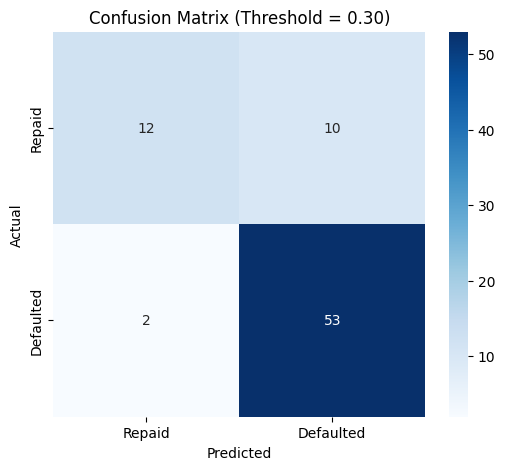

In [25]:
model.eval()
y_val_probs = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)  
        y_val_probs.extend(probs.cpu().numpy())
y_val_probs = np.array(y_val_probs)
y_val_true = y_val 

prec, rec, thresholds = precision_recall_curve(y_val_true, y_val_probs)
denom = prec + rec
f1 = np.zeros_like(denom)
mask = denom != 0
f1[mask] = 2 * prec[mask] * rec[mask] / denom[mask]
best_thresh = thresholds[np.argmax(f1[:-1])]
print("Best threshold from validation set for F1:", best_thresh)

y_test_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())
y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

In [26]:
# Data sets
dtrain = xgb.DMatrix(X_train_bal, label=y_train_bal)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test) 

In [27]:
# Model
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42,
}

evals = [(dtrain, "train"), (dval, "validation")]

In [28]:
# Train
model_b = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-logloss:0.66429	validation-logloss:0.67654
[50]	train-logloss:0.23502	validation-logloss:0.47746
[100]	train-logloss:0.14951	validation-logloss:0.50338
[101]	train-logloss:0.14880	validation-logloss:0.50472


Best threshold for F1: 0.39510784
              precision    recall  f1-score   support

      Repaid       0.81      0.59      0.68        22
   Defaulted       0.85      0.95      0.90        55

    accuracy                           0.84        77
   macro avg       0.83      0.77      0.79        77
weighted avg       0.84      0.84      0.84        77

Accuracy: 84.42%
ROC AUC: 0.827
TP=52, FP=9, TN=13, FN=3
Accuracy for class 'Repaid': 59.09%
Accuracy for class 'Defaulted': 94.55%


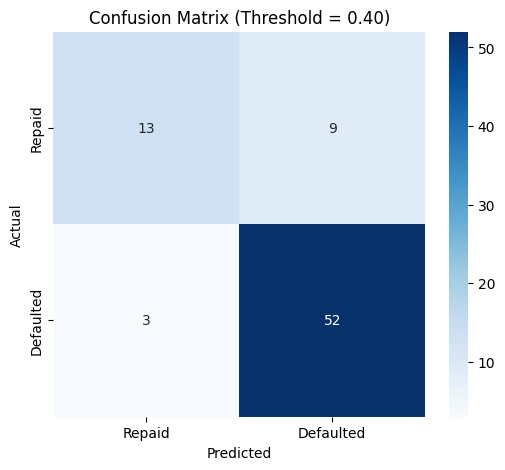

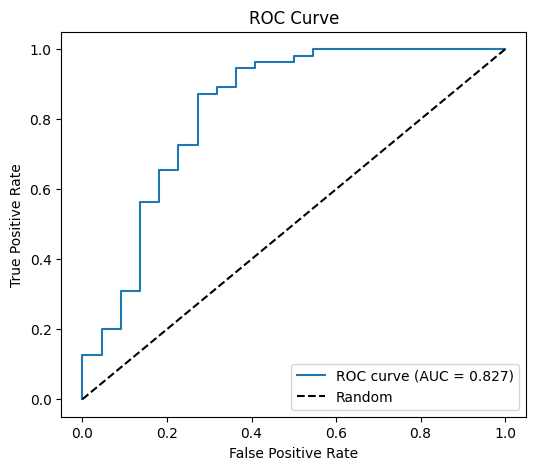

In [29]:
# Evaluation
y_probs = model_b.predict(dtest) 

prec, rec, thresholds = precision_recall_curve(y_test, y_probs) 
denom = prec + rec
f1 = np.zeros_like(denom)
mask = denom != 0
f1[mask] = 2 * prec[mask] * rec[mask] / denom[mask]
best_thresh = thresholds[np.argmax(f1[:-1])]
y_pred_opt = (y_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_pred_opt)
cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_probs) 
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()